In [143]:
import matplotlib.pyplot as plt
import cv2 
import pytesseract
from PIL import Image
from reportlab.lib.pagesizes import A4, letter
# Adding custom options

custom_config = r'--oem 2 --psm 11 -l fra+eng'



In [144]:
A4_int = (int(round(A4[0])), int(round(A4[1])))

In [145]:
# img = cv2.imread('img/test1.jpg',cv2.IMREAD_UNCHANGED)
img = cv2.imread('img/test7.png',cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (A4_int[0],A4_int[1]) ,interpolation=cv2.INTER_CUBIC)
img = cv2.resize(img, None,fx=2,fy=2 ,interpolation=cv2.INTER_CUBIC)

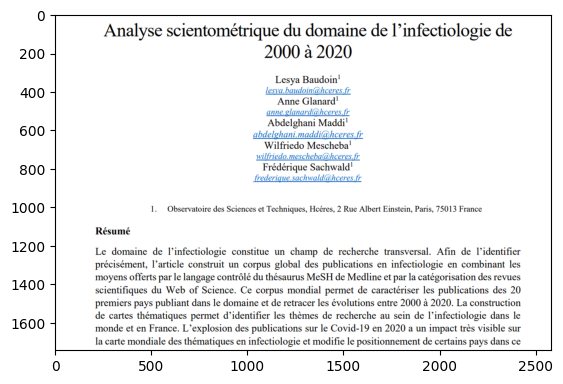

In [146]:
plt.imshow(img)

In [147]:
# cv2.imshow('image',img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [148]:
# test = pytesseract.image_to_string(Image.fromarray(img), config=custom_config)
# test

In [149]:
# Perform OCR on the RGB image using pytesseract
text = pytesseract.image_to_data(Image.fromarray(img),output_type='dict',config=custom_config)

In [150]:
boxes = len(text['level'])
for i in range(boxes ):
    (x, y, w, h) = (text['left'][i], text['top'][i], text['width'][i], text['height'][i])
    #Draw box        
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

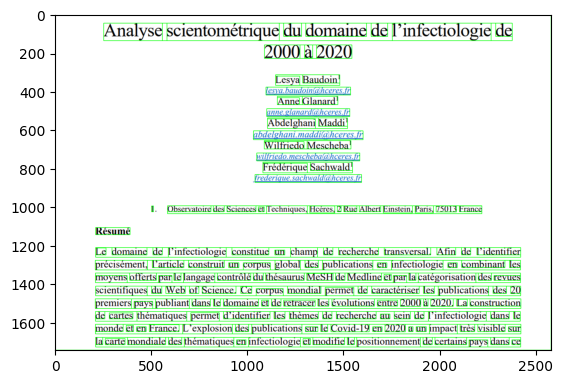

In [151]:
plt.imshow(img)

In [152]:
for i in range(boxes ):
    (x, y, w, h,chara) = (text['left'][i] , text['top'][i], text['width'][i], text['height'][i],text["text"][i])
    print(x, y, w, h,chara)

0 0 2580 1744 
253 47 2125 91 
253 47 2125 91 
253 47 2125 91 
253 47 305 91 Analyse
582 47 584 91 scientométrique
1189 47 93 69 du
1304 47 316 69 domaine
1644 47 86 69 de
1754 47 514 91 l’infectiologie
2292 47 86 69 de
1089 160 455 70 
1089 160 455 70 
1089 160 455 70 
1089 160 185 70 2000
1298 160 42 68 à
1360 160 184 70 2020
1147 315 334 55 
1147 315 334 55 
1147 315 334 55 
1147 322 126 48 Lesya
1288 315 193 43 Baudoin'
1097 379 440 41 
1097 379 440 41 
1097 379 440 41 
1097 379 440 41 lesva.baudoin(@hceres.fr
1156 427 315 43 
1156 427 315 43 
1156 427 315 43 
1156 434 115 36 Anne
1286 427 185 43 Glanard'
1101 491 432 41 
1101 491 432 41 
1101 491 432 41 
1101 491 432 41 anne.glanard@hceres.fr
1105 539 416 55 
1105 539 416 55 
1105 539 416 55 
1105 544 249 50 Abdelghani
1370 539 151 43 Maddi'
1032 606 570 46 
1032 606 570 46 
1032 606 570 46 
1032 606 570 46 abdelghani.maddi@hceres.fr
1088 657 451 43 
1088 657 451 43 
1088 657 451 43 
1088 662 207 38 Wilfriedo
1311 657 228 43 Mesch

In [153]:
def adjust_text_boxes(text_data):
    # Zip the text data into tuples for easier manipulation
    boxes = list(zip([pos * A4[0] / img.shape[1] for pos in text_data['left']], 
                     [A4[1] - pos * A4[1]/img.shape[0] for pos in text_data['top']], 
                     [pos * A4[0] / img.shape[1] for pos in text_data['width']],
                       [pos * A4[1]/img.shape[0]  for pos in text_data['height']],
                         text_data['text']))

    # Sort the text boxes based on their vertical positions (top to bottom)
    sorted_boxes = sorted(boxes, key=lambda box: box[1])

    # Set a threshold for height difference to identify text on the same line
    threshold_height = 16 * A4[1]/img.shape[0]  # Adjust this value as needed
    threshold_font_size = 4
    # Correct text boxes that are too close in height
    for i in range(len(sorted_boxes) - 1):
        current_box = sorted_boxes[i]
        next_box = sorted_boxes[i + 1]

        # If the vertical distance between the current and next box is within the threshold
        if abs(current_box[1] - next_box[1]) < threshold_height:
            # Adjust the next box's top position to align it with the current box
            new_top = current_box[1]
            sorted_boxes[i + 1] = (next_box[0], new_top, next_box[2], next_box[3], next_box[4])
        if abs(current_box[3] - next_box[3]) < threshold_font_size:
                
                sorted_boxes[i + 1] = (sorted_boxes[i + 1][0], sorted_boxes[i + 1][1], sorted_boxes[i + 1][2], current_box[3], sorted_boxes[i + 1][4]) 
 

    # Unzip the corrected data
    corrected_data = {
        'left': [box[0] for box in sorted_boxes],
        'top': [box[1] for box in sorted_boxes],
        'width': [box[2] for box in sorted_boxes],
        'height': [box[3] for box in sorted_boxes],
        'text': [box[4] for box in sorted_boxes]
    }

    return corrected_data

# Example usage:
# Assuming 'text' contains the extracted text data similar to what you previously retrieved from Tesseract
corrected_text_data = adjust_text_boxes(text)

In [156]:
set(corrected_text_data["height"])

{12.068373907390018,
 14.964783645163623,
 17.37845842664163,
 17.861193382937227,
 18.34392833923283,
 19.792133208119633,
 20.757603120710833,
 21.24033807700643,
 24.136747814780037,
 26.55042259625804,
 33.30871198439645,
 33.79144694069205,
 43.92888102289967,
 841.8897637795277}

In [155]:
from reportlab.pdfgen import canvas

def hello(c,left,top,text,pixel):
    c.setFont("Helvetica", pixel)
    c.drawString(left,top,text,charSpace=0.25)
c = canvas.Canvas("hello.pdf")
boxes_correct = len(corrected_text_data["left"])
for i in range(boxes ):
    if corrected_text_data["text"][i] !="": 
        (x, y, w, h,chara) = (corrected_text_data['left'][i]  ,corrected_text_data['top'][i], corrected_text_data['width'][i], corrected_text_data['height'][i],corrected_text_data["text"][i])
        hello(c,x,y,chara,h)
        # c.rect(x, y, w, h-1)
c.showPage()
c.save()